In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
import dpkt
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

tf_ver: 1.15.0 gpflow_ver: 1.5.0


2022-06-30 15:53:29.331069: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2022-06-30 15:53:29.360341: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2799950000 Hz
2022-06-30 15:53:29.362339: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564f1d9dffc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-30 15:53:29.362367: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-30 15:53:29.364426: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:XLA_GPU:0
/device:GPU:0


2022-06-30 15:53:30.327461: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564f1ef9b3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-30 15:53:30.327503: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2022-06-30 15:53:30.327892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
2022-06-30 15:53:30.328207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-30 15:53:30.329937: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-30 15:53:30.331294: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.

In [2]:
plt.rcParams['figure.dpi'] = 100
np.random.seed(123456)

# Load data

Input filename

In [3]:
filename='./data/facebook_chat_4b.pcap'

In [4]:
counter=0
last_time=0
data_list=[]

for ts, pkt in dpkt.pcap.Reader(open(filename,'rb')):
    if last_time==0:
        last_time=int(ts)
    else:
        cur_time=int(ts)
        if cur_time==last_time:
            counter+=1
        else:
            data_list.append(counter)
            last_time=cur_time
            counter=1
data_list.append(counter)

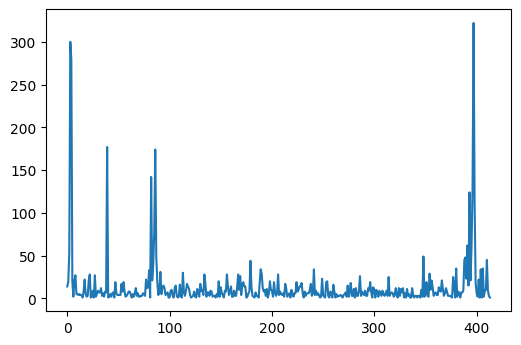

In [5]:
plt.plot(data_list)

# Build data

In [6]:
data_list=np.asarray(data_list)
l=len(data_list)
train_size=int(0.6*l)
test_size=l-train_size

In [7]:
M=l//3

In [8]:
win=5
X_train=np.zeros((train_size-win, win))
Y_train=np.zeros((train_size-win, 1))
X_test=np.zeros((test_size-win, win))
Y_test=np.zeros((test_size-win, 1))

In [9]:
for i in range(train_size-win):
    X_train[i]=data_list[i:i+win]
    Y_train[i,0]=data_list[i+win]

In [10]:
for i in range(test_size-win):
    X_test[i]=data_list[train_size+i:train_size+i+win]
    Y_test[i,0]=data_list[train_size+i+win]

In [11]:
def normalize_data(data, mu, std):
    res = (data-mu) / std
    return res

def unnormalize_data(data, mu, std):
    res = data * std + mu
    return res

In [12]:
trX0 = X_train
trY0 = Y_train

teX0 = X_test
teY0 = Y_test

In [13]:
trX0, teX0 = trX0[:, None, :], teX0[:, None, :]
trY0, teY0 = trY0[:, None, :], teY0[:, None, :]

In [14]:
mu_trX0, std_trX0 = np.mean(trX0, axis=0), np.std(trX0, axis=0)
mu_trY0, std_trY0 = np.mean(trY0, axis=0), np.std(trY0, axis=0)
# mu_teX0, std_teX0 = np.mean(teX0, axis=0), np.std(teX0, axis=0)
# mu_teY0, std_teY0 = np.mean(teY0, axis=0), np.std(teY0, axis=0)

In [15]:
trX = normalize_data(trX0, mu_trX0, std_trX0)
trY = normalize_data(trY0, mu_trY0, std_trY0)
teX = normalize_data(teX0, mu_trX0, std_trX0)
teY = normalize_data(teY0, mu_trY0, std_trY0)

In [16]:
gmat = np.eye(1)

# Data visualization

In [17]:
def imshow2d(x):
    plt.imshow(x.reshape(x.shape[0], -1))
    plt.colorbar()

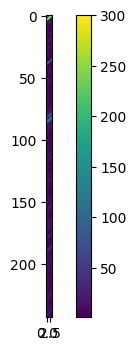

In [18]:
imshow2d(trX0)

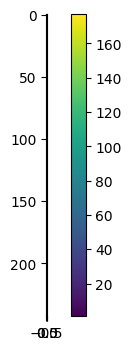

In [19]:
imshow2d(trY0)

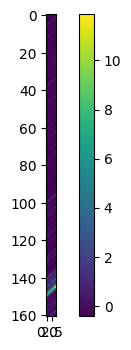

In [20]:
imshow2d(teX)

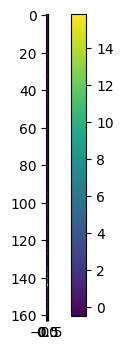

In [21]:
imshow2d(teY)

# Training

In [22]:
nodes = gmat.shape[0]


Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (138, 1, 5)


In [23]:
adj = gmat.astype('float64')
input_adj = adj # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)

In [24]:
with gpflow.defer_build():
    m_dgpg = DGPG(trX, trY, Z, [win], Gaussian(), input_adj,
                  agg_op_name='concat3d', ARD=True,
                  is_Z_forward=True, mean_trainable=False, out_mf0=True,
                  num_samples=20, minibatch_size=80,
                  kern_type='RBF'
                  #kern_type='Matern32'
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
m_dgpg.compile()
model = m_dgpg

2022-06-30 15:53:32.644575: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


input-output dim (5(agg:5)->1)
func __init__ consumed 1.3s


In [25]:
session = m_dgpg.enquire_session()
optimiser = gpflow.train.AdamOptimizer(0.01)
global_step = mon.create_global_step(session)

In [26]:
maxiter=2000

exp_path="./exp/tmp"
#exp_path="./exp/temp"

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

checkpoint_task = mon.CheckpointTask(checkpoint_dir=exp_path)\
        .with_name('checkpoint')\
        .with_condition(mon.PeriodicIterationCondition(15))\

with mon.LogdirWriter(exp_path) as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task, checkpoint_task] # [print_task, tensorboard_task]
    
       
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)

2022-06-30 15:53:35.051504: I tensorflow/core/kernels/cuda_solvers.cc:159] Creating CudaSolver handles for stream 0x564f20a785d0
2022-06-30 15:53:35.051695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2022-06-30 15:53:35.225115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


Tasks execution time summary:
tensorboard:	0.2707 (sec)
checkpoint:	15.6167 (sec)


# Results

In [27]:
from jack_utils.my_metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def assess_model_rmse(model, X_batch, Y_batch, S = 10):
    m, v = model.predict_y(X_batch, S)
    pred = np.mean(m, axis=0)
    var = np.mean(v, axis=0)
    loss = np.sum((Y_batch.flatten()-pred.flatten())**2)
    return loss, pred, var

def batch_assess_rmse(model, X, Y, batch_size=1, S=10):
    n_batches = max(int(len(X)/batch_size), 1)
    rms = len(X) - n_batches*batch_size
    losses, preds, varis = [], [], []
    Xr, Yr = X[-rms:, :], Y[-rms:, :]
    for X_batch, Y_batch in zip(np.split(X[:n_batches*batch_size], n_batches), np.split(Y[:n_batches*batch_size], n_batches)):
        l, pred, vari = assess_model_rmse(model, X_batch, Y_batch, S=S)
        losses.append(l)
        preds.append(pred)
        varis.append(vari)
    if rms > 0:
        l, pred, vari = assess_model_rmse(model, Xr, Yr, S=S)
        losses.append(l)        
        preds.append(pred)
        varis.append(vari)
    ndata = Y.shape[0] * Y.shape[1]
    avg_loss = np.sqrt(np.sum(losses) / ndata)
    y_pred = np.concatenate(preds)
    y_var = np.concatenate(varis)
    return avg_loss, y_pred, y_var

In [29]:
# make predictions of our model
sample_X0, sample_Y0 = teX0, teY0.squeeze()
sample_X, sample_Y = teX, teY.squeeze()

In [30]:
%%time
pred_rmse, predY, varY = batch_assess_rmse(model, sample_X.reshape(sample_X.shape[0], -1), sample_Y.reshape(sample_Y.shape[0], -1))
print(pred_rmse)

1.5409537100389241
CPU times: user 2.17 s, sys: 126 ms, total: 2.3 s
Wall time: 1.61 s


In [31]:
predY0 = unnormalize_data(predY[:,:,None], mu_trY0, std_trY0).squeeze()

In [32]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_dgp = [np.round(f(predY0, sample_Y0.squeeze()), 3) for f in metrics]
e_last = [np.round(f(sample_X0[:,:,-1], sample_Y0.squeeze()), 3) for f in metrics]
e_ha = [np.round(f(sample_X0.mean(axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
e_mid = [np.round(f(np.median(sample_X0, axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('ours DGP:\t', e_dgp)
print('Last baseline:\t', e_last)
print('5s mean baseline:\t', e_ha)
print('5s median baseline:\t', e_mid)

metrics:	[mae | rmse | mape]
ours DGP:	 [11.671, 30.281, 0.969]
Last baseline:	 [17.419, 43.516, 3.537]
5s mean baseline:	 [15.852, 37.469, 1.69]
5s median baseline:	 [14.597, 36.219, 2.281]


# Variance analysis

In [33]:
std_varY0 = np.sqrt(varY)*std_trY0.reshape(1,varY.shape[1])

In [34]:
def correct_rate(predY0, std_varY0, sample_Y0, ndev):
    predY0_ub = predY0 + std_varY0*ndev
    predY0_lb = predY0 - std_varY0*ndev
    tf_mat = np.logical_and(predY0_lb <= sample_Y0, sample_Y0 <= predY0_ub) 
    correct_rate = np.sum(tf_mat) / np.product(tf_mat.shape)
    return correct_rate

In [35]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=1)

0.9361135758651287

In [36]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=2)

0.9739979167470391

In [37]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=3)

0.9751552795031055

In [38]:
model

,class,prior,transform,trainable,shape,fixed_shape,value
DGPG/layers/0/feature/Z,Parameter,None,(none),True,"(138, 1, 5)",True,"[[[-0.13275430959422013, -0.24942834438051653,..."
DGPG/layers/0/kern/lengthscales,Parameter,None,+ve,True,"(1, 5)",True,"[[0.896794828090852, 0.8814595860444212, 0.887..."
DGPG/layers/0/kern/variance,Parameter,None,+ve,True,"(1,)",True,[1.0697523631706873]
DGPG/layers/0/q_mu,Parameter,None,(none),True,"(1, 138, 1)",True,"[[[0.01792111742580625], [0.007861841345147936..."
DGPG/layers/0/q_sqrt,Parameter,None,LoTri_3d->matrix,True,"(1, 1, 138, 138)",True,[[[[0.54031699 0. 0. 0. ...
DGPG/likelihood/likelihood/variance,Parameter,None,+ve,True,(),True,1.2582289978977677


In [39]:
import pandas as pd

z=model.layers[0].feature.Z.value.squeeze()

In [40]:
print('挖掘特征个数：%d\n'%M)
pd.DataFrame(z).head(10)

挖掘特征个数：138



,0,1,2,3,4
0,-0.132754,-0.249428,0.423958,0.078145,-0.445935
1,-0.267506,-0.433463,-0.227401,-0.390740,-0.230162
2,-0.438639,-0.154897,-0.330329,-0.211759,-0.259903
3,-0.368874,0.016615,0.058398,-0.026443,0.090867
4,-0.345466,-0.245945,1.030168,-0.047157,-0.400346
5,-0.261867,-0.407970,-0.366360,-0.357375,-0.362147
6,0.168912,1.231610,8.945155,8.320631,0.301419
7,1.990409,0.199696,1.015908,5.511156,8.241242
8,-0.255872,-0.372170,-0.174704,-0.181685,6.325397
9,-0.374392,-0.411455,0.149317,-0.411065,-0.440744


In [41]:
from sklearn.manifold import TSNE
z2d = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(z)
z2d.shape

(138, 2)

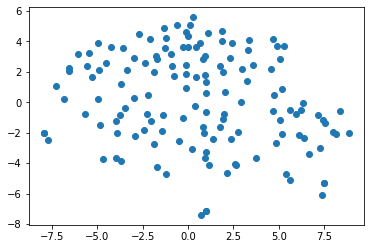

In [42]:
plt.scatter(z2d[:,0],z2d[:,1])